In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For modeling
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Configure display settings
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn')

/home/ankur/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Load the dataset

In [2]:
df = pd.read_csv('./US_Accidents_March23.csv')
print("Dataset Shape:", df.shape)

Dataset Shape: (7728394, 46)


### Initial Data Exploration

In [3]:
# Display first few rows
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
# Display data info
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Hum

In [5]:
# Check missing values
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentages.round(2)
})
missing_info[missing_info['Missing Values'] > 0]

,Missing Values,Missing Percentage
End_Lat,3402762,44.03
End_Lng,3402762,44.03
Description,5,0.00
Street,10869,0.14
City,253,0.00
Zipcode,1915,0.02
Timezone,7808,0.10
Airport_Code,22635,0.29
Weather_Timestamp,120228,1.56
Temperature(F),163853,2.12


### Target Variable Analysis

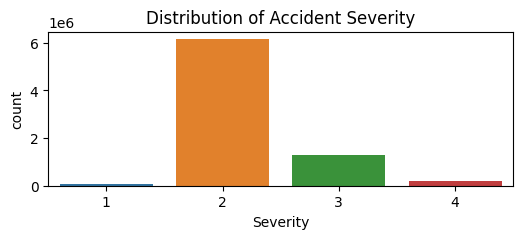

Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64

In [6]:
# Analyze Severity distribution
plt.figure(figsize=(6, 2))
sns.countplot(data=df, x='Severity')
plt.title('Distribution of Accident Severity')
plt.show()

# Display severity statistics
severity_stats = df['Severity'].value_counts().sort_index()
display(severity_stats)

### Temporal Feature Analysis

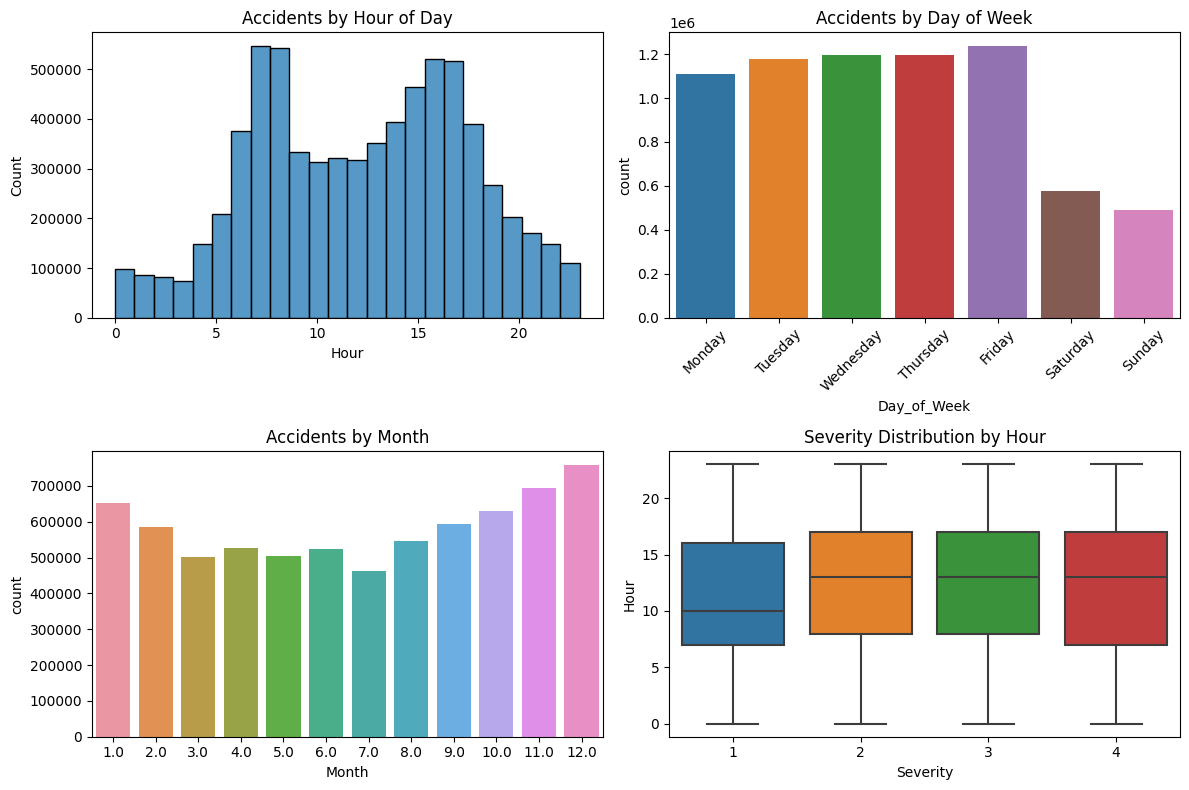

In [7]:
# Convert Start_Time to datetime with error handling
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Extract temporal features
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.day_name()
df['Month'] = df['Start_Time'].dt.month

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Hour distribution
sns.histplot(data=df, x='Hour', bins=24, ax=axes[0,0])
axes[0,0].set_title('Accidents by Hour of Day')

# Day of week distribution
sns.countplot(data=df, x='Day_of_Week', 
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
              ax=axes[0,1])
axes[0,1].set_title('Accidents by Day of Week')
axes[0,1].tick_labels = axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

# Month distribution
sns.countplot(data=df, x='Month', ax=axes[1,0])
axes[1,0].set_title('Accidents by Month')

# Severity by hour
sns.boxplot(data=df, x='Severity', y='Hour', ax=axes[1,1])
axes[1,1].set_title('Severity Distribution by Hour')

plt.tight_layout()
plt.show()

### Weather Analysis

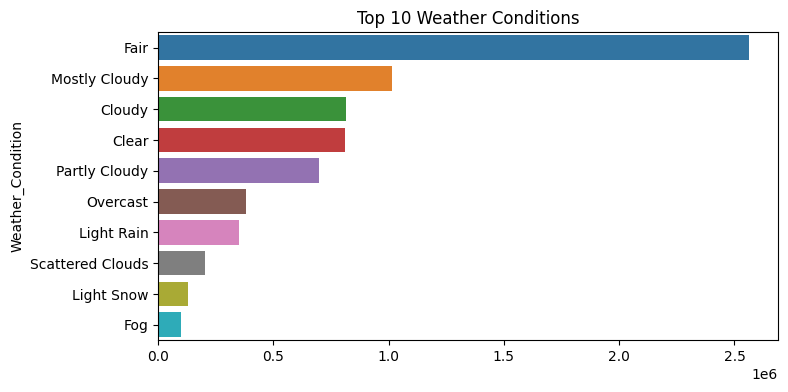

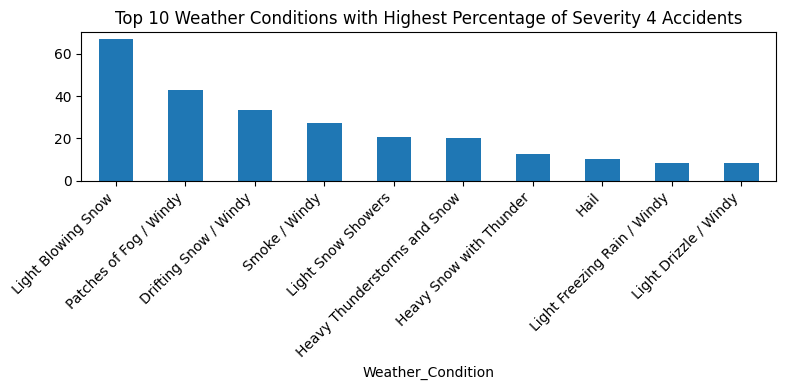

In [8]:
# Analyze weather conditions
plt.figure(figsize=(8, 4))
weather_counts = df['Weather_Condition'].value_counts().head(10)
sns.barplot(x=weather_counts.values, y=weather_counts.index)
plt.title('Top 10 Weather Conditions')
plt.show()

# Weather correlation with severity
weather_severity = pd.crosstab(df['Weather_Condition'], df['Severity'])
weather_severity_pct = weather_severity.div(weather_severity.sum(axis=1), axis=0) * 100

# Display top 10 weather conditions by severity 4
weather_severity_4 = weather_severity_pct[4].sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
weather_severity_4.plot(kind='bar')
plt.title('Top 10 Weather Conditions with Highest Percentage of Severity 4 Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Geographic Analysis

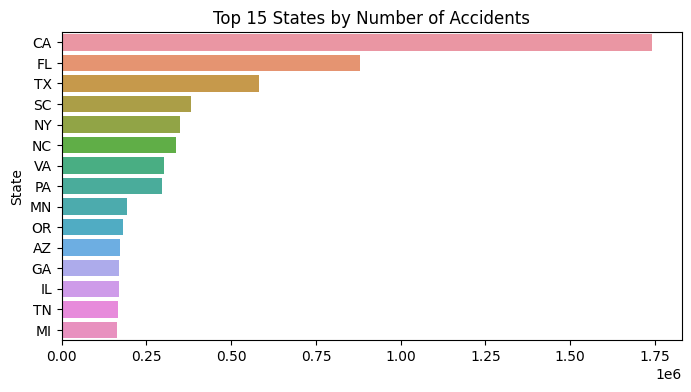

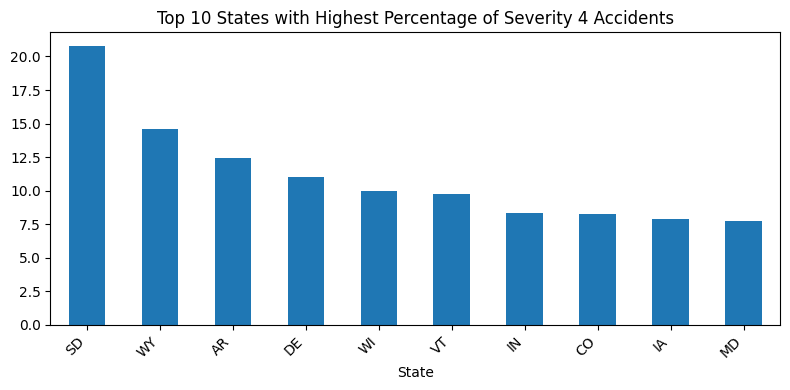

In [9]:
# State-wise analysis
plt.figure(figsize=(8, 4))
state_counts = df['State'].value_counts().head(15)
sns.barplot(x=state_counts.values, y=state_counts.index)
plt.title('Top 15 States by Number of Accidents')
plt.show()

# Severity distribution by state
state_severity = pd.crosstab(df['State'], df['Severity'])
state_severity_pct = state_severity.div(state_severity.sum(axis=1), axis=0) * 100

# Display top 10 states with highest severity 4 percentage
state_severity_4 = state_severity_pct[4].sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
state_severity_4.plot(kind='bar')
plt.title('Top 10 States with Highest Percentage of Severity 4 Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Feature Correlations

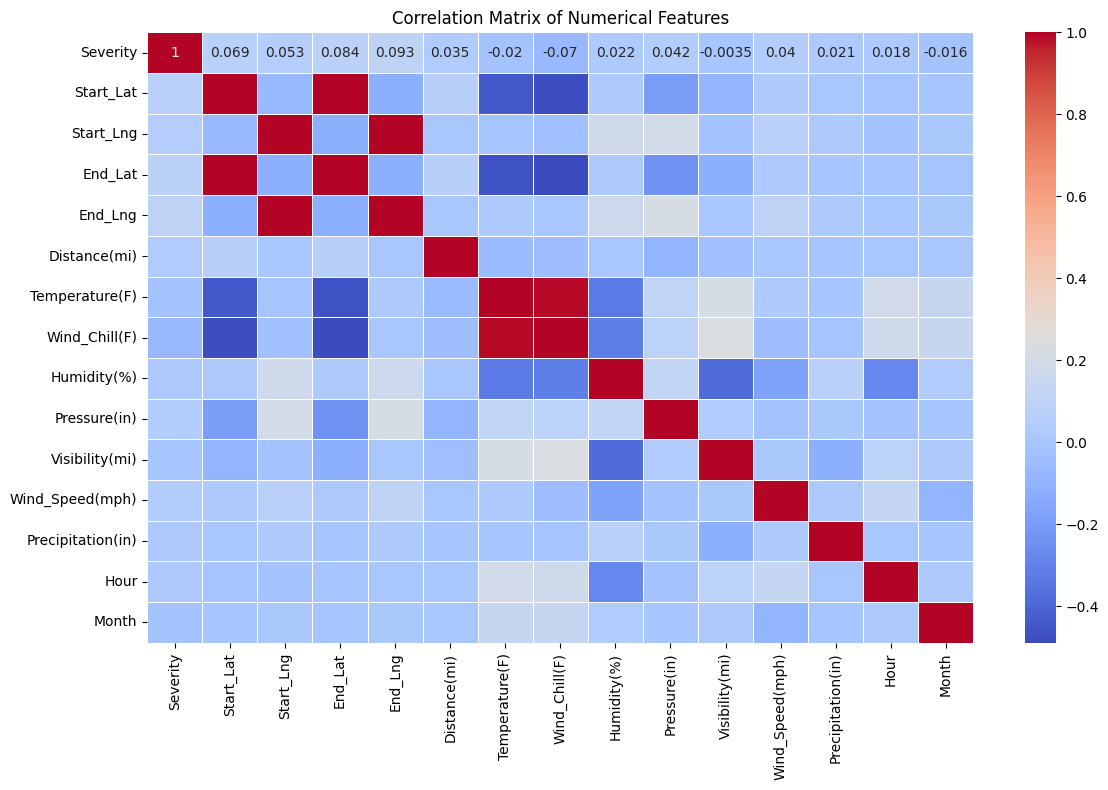

In [10]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [11]:
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,Day_of_Week,Month
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.010,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,5.0,Monday,2.0
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.010,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,6.0,Monday,2.0
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.010,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,6.0,Monday,2.0
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.010,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,7.0,Monday,2.0
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,7.0,Monday,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,A-7777757,Source1,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379360,33.99888,-117.37094,0.543,At Market St - Accident.,Pomona Fwy E,Riverside,Riverside,CA,92501,US,US/Pacific,KRAL,2019-08-23 17:53:00,86.0,86.0,40.0,28.92,10.0,W,13.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,18.0,Friday,8.0
7728390,A-7777758,Source1,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148060,32.76555,-117.15363,0.338,At Camino Del Rio/Mission Center Rd - Accident.,I-8 W,San Diego,San Diego,CA,92108,US,US/Pacific,KMYF,2019-08-23 18:53:00,70.0,70.0,73.0,29.39,10.0,SW,6.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,19.0,Friday,8.0
7728391,A-7777759,Source1,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847790,33.77740,-117.85727,0.561,At Glassell St/Grand Ave - Accident. in the ri...,Garden Grove Fwy,Orange,Orange,CA,92866,US,US/Pacific,KSNA,2019-08-23 18:53:00,73.0,73.0,64.0,29.74,10.0,SSW,10.0,0.00,Partly Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,19.0,Friday,8.0
7728392,A-7777760,Source1,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403020,33.98311,-118.39565,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,San D

### Initial Data Processing

In [12]:
def preprocess_data(df):
    """
    Perform initial data preprocessing
    """
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Handle missing values
    # For numerical columns, fill with median
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # For categorical columns, fill with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    # Convert timestamps
    df_processed['Start_Time'] = pd.to_datetime(df_processed['Start_Time'], format='mixed')
    df_processed['End_Time'] = pd.to_datetime(df_processed['End_Time'], format='mixed')
    
    # Create duration feature
    df_processed['Duration_Minutes'] = ((df_processed['End_Time'] - 
                                       df_processed['Start_Time']).dt.total_seconds() / 60)
    
    # Extract temporal features
    df_processed['Hour'] = df_processed['Start_Time'].dt.hour
    df_processed['Day_of_Week'] = df_processed['Start_Time'].dt.day_name()
    df_processed['Month'] = df_processed['Start_Time'].dt.month
    df_processed['Year'] = df_processed['Start_Time'].dt.year
    df_processed = df_processed.drop(columns=['Description', 'Street'] ,axis=1)
    df_processed.dropna(subset=['Hour', 'Month', 'Duration_Minutes'], inplace=True)
    return df_processed

# Process the data

df_engineered = preprocess_data(df)
print("Processed data shape:", df_engineered.shape)
df_engineered.head(5)

Processed data shape: (6985228, 49)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,Day_of_Week,Month,Duration_Minutes,Year
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,36.183495,-88.02789,0.01,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,62.0,91.0,29.68,10.0,Calm,7.0,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,5.0,Monday,2.0,314.0,2016.0
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,36.183495,-88.02789,0.01,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,62.0,100.0,29.65,10.0,Calm,7.0,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,6.0,Monday,2.0,30.0,2016.0
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,36.183495,-88.02789,0.01,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,6.0,Monday,2.0,30.0,2016.0
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,36.183495,-88.02789,0.01,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,7.0,Monday,2.0,30.0,2016.0
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,36.183495,-88.02789,0.01,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,7.0,Monday,2.0,30.0,2016.0


### Analysis of Engineered Features

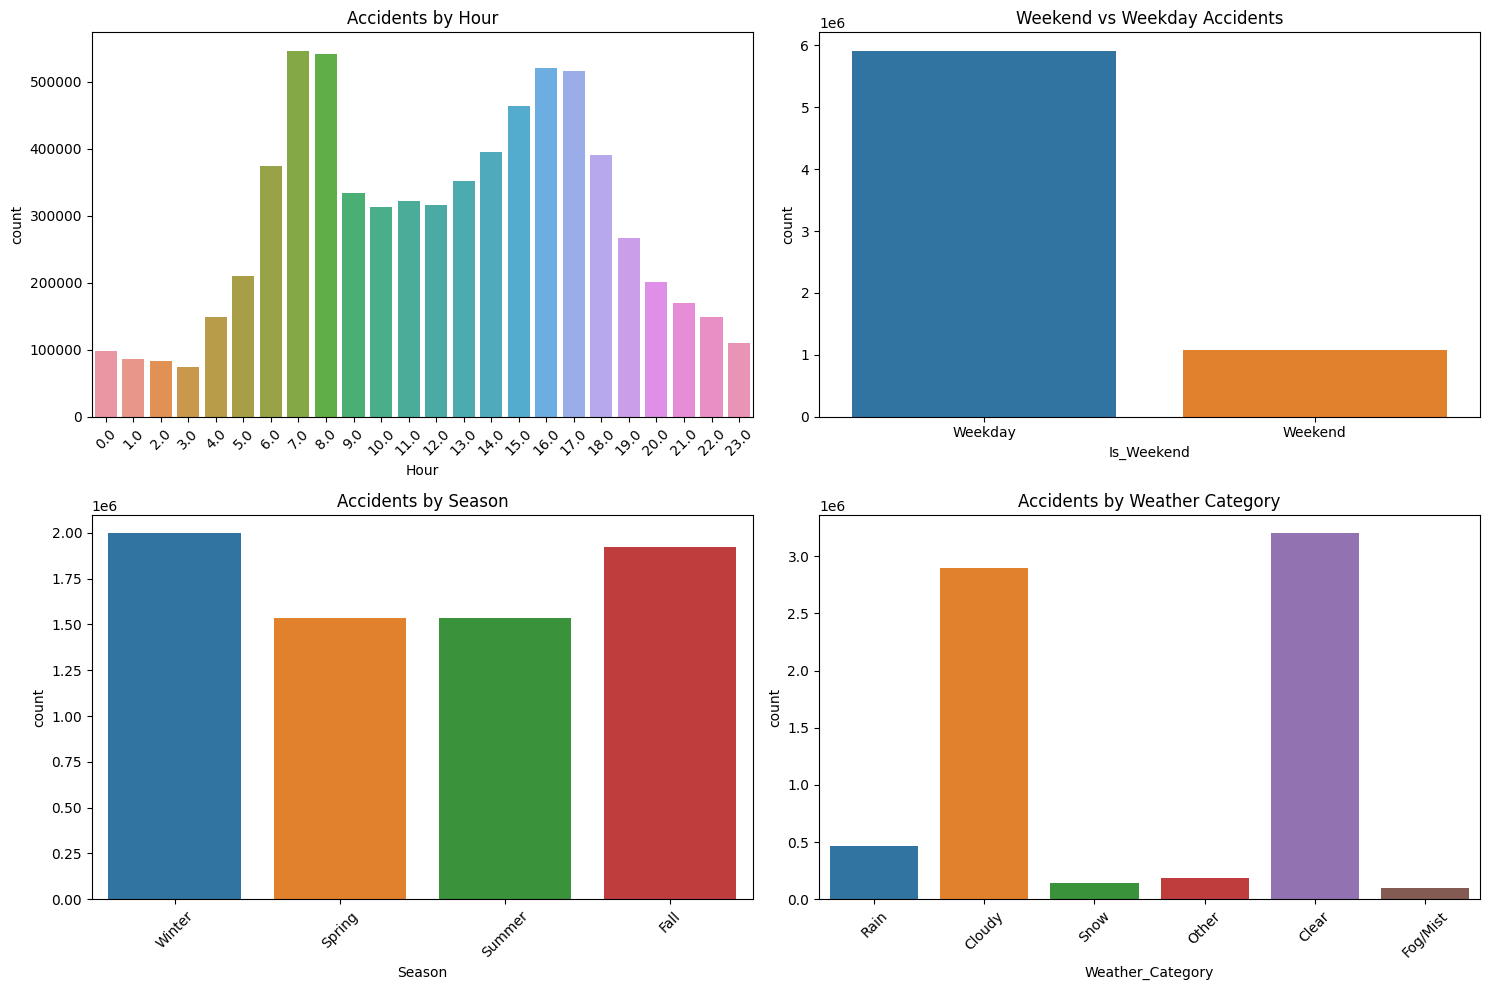

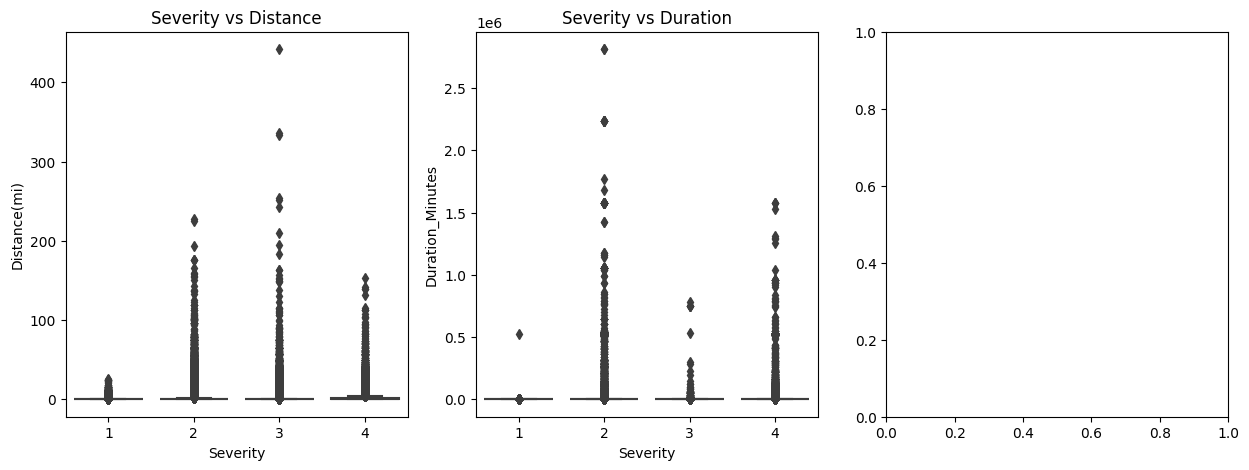

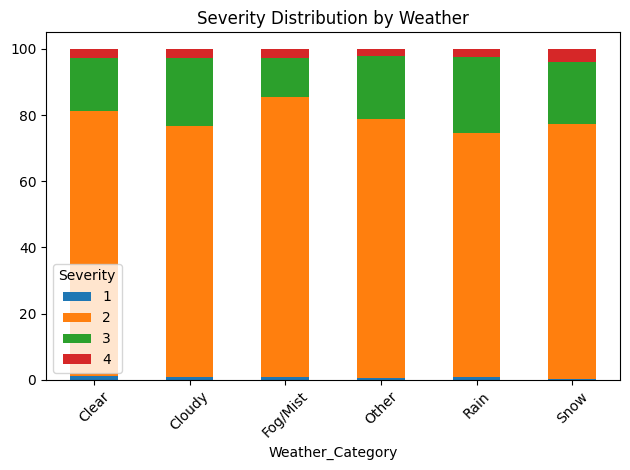

In [13]:
# Create Is_Weekend column
df_engineered['Is_Weekend'] = df_engineered['Day_of_Week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Create Season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_engineered['Season'] = df_engineered['Month'].apply(get_season)

# Create Weather_Category column
def categorize_weather(condition):
    if 'Rain' in condition:
        return 'Rain'
    elif 'Snow' in condition:
        return 'Snow'
    elif 'Fog' in condition or 'Mist' in condition:
        return 'Fog/Mist'
    elif 'Clear' in condition or 'Fair' in condition:
        return 'Clear'
    elif 'Cloud' in condition or 'Overcast' in condition:
        return 'Cloudy'
    else:
        return 'Other'

df_engineered['Weather_Category'] = df_engineered['Weather_Condition'].apply(categorize_weather)

# Analyze temporal patterns
plt.figure(figsize=(15, 10))

# Hour analysis
plt.subplot(2, 2, 1)
sns.countplot(data=df_engineered, x='Hour')
plt.title('Accidents by Hour')
plt.xticks(rotation=45)

# Weekend vs Weekday
plt.subplot(2, 2, 2)
sns.countplot(data=df_engineered, x='Is_Weekend')
plt.title('Weekend vs Weekday Accidents')
plt.xticks([0, 1], ['Weekday', 'Weekend'])

# Season analysis
plt.subplot(2, 2, 3)
sns.countplot(data=df_engineered, x='Season')
plt.title('Accidents by Season')
plt.xticks(rotation=45)

# Weather Category
plt.subplot(2, 2, 4)
sns.countplot(data=df_engineered, x='Weather_Category')
plt.title('Accidents by Weather Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analyze relationship with severity
plt.figure(figsize=(15, 5))

# Replace 'POI_Density' with an existing column, e.g., 'Distance(mi)'
plt.subplot(1, 3, 1)
sns.boxplot(data=df_engineered, x='Severity', y='Distance(mi)')
plt.title('Severity vs Distance')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_engineered, x='Severity', y='Duration_Minutes')
plt.title('Severity vs Duration')

plt.subplot(1, 3, 3)
severity_by_weather = pd.crosstab(df_engineered['Weather_Category'], 
                                 df_engineered['Severity'], 
                                 normalize='index') * 100
severity_by_weather.plot(kind='bar', stacked=True)
plt.title('Severity Distribution by Weather')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Feature Selection and Model Preparation

In [14]:
from sklearn.model_selection import train_test_split

# Select features for modeling
features = [
    # Temporal features
    'Hour', 'Is_Weekend', 'Month', 'Duration_Minutes',
    
    # Weather features
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)',
    
    # Binary features
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
    'Traffic_Calming', 'Traffic_Signal',
    
    # Categorical features
    'Weather_Category', 'Season', 'State'
]

X = df_engineered[features]
y = df_engineered['Severity']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5238921, 24)
Validation set shape: (1047784, 24)
Test set shape: (698523, 24)


### Model Development and Training

In [15]:
X

,Hour,Is_Weekend,Month,Duration_Minutes,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Weather_Category,Season,State
0,5.0,0,2.0,314.000000,36.9,91.0,29.68,10.0,7.0,False,False,False,False,False,False,False,False,False,False,False,False,Rain,Winter,OH
1,6.0,0,2.0,30.000000,37.9,100.0,29.65,10.0,7.0,False,False,False,False,False,False,False,False,False,False,False,False,Rain,Winter,OH
2,6.0,0,2.0,30.000000,36.0,100.0,29.67,10.0,3.5,False,False,False,False,False,False,False,False,False,False,False,True,Cloudy,Winter,OH
3,7.0,0,2.0,30.000000,35.1,96.0,29.64,9.0,4.6,False,False,False,False,False,False,False,False,False,False,False,False,Cloudy,Winter,OH
4,7.0,0,2.0,30.000000,36.0,89.0,29.65,6.0,3.5,False,False,False,False,False,False,False,False,False,False,False,True,Cloudy,Winter,OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,18.0,0,8.0,28.600000,86.0,40.0,28.92,10.0,13.0,False,False,False,False,False,False,False,False,False,False,False,False,Clear,Summer,CA
7728390,19.0,0,8.0,26.883333,70.0,73.0,29.39,10.0,6.0,False,False,False,False,False,False,False,False,False,False,False,False,Clear,Summer,CA
7728391,19.0,0,8.0,28.466667,73.0,64.0,29.74,10.0,10.0,False,False,False,False,True,False,False,False,False,False,False,False,Cloudy,Summer,CA
7728392,19.0,0,8.0,29.350000,71.0,81.0,29.62,10.0,8.0,False,False,False,False,False,False,False,False,False,False,False,False,Clear,Summer,CA


In [16]:
# utils
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomClassifier(BaseEstimator, ClassifierMixin):
    def __sklearn_tags__(self):
        return {"non_deterministic": False}



Training LightGBM...
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing batch 43..

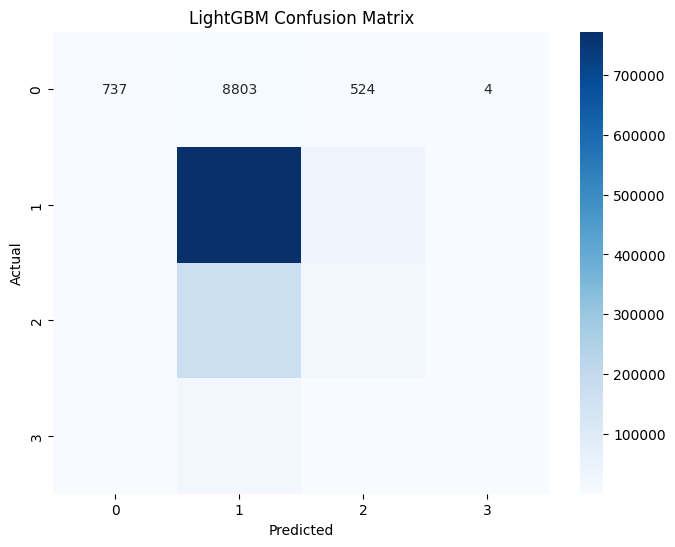


Training GradientBoosting...
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing ba

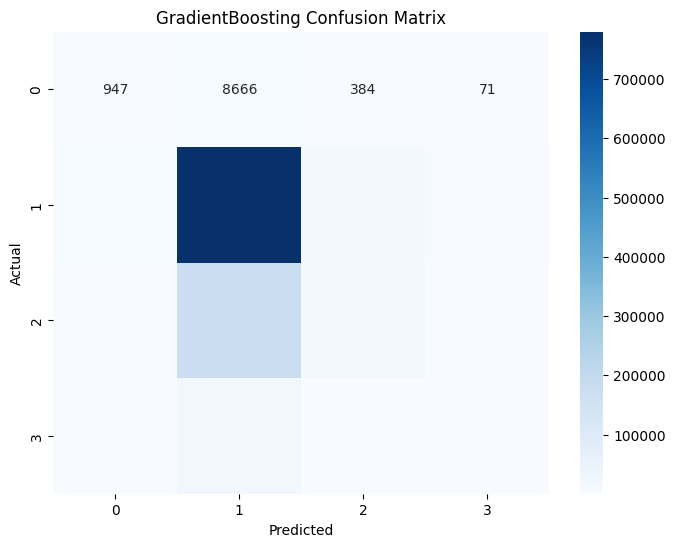


Training RandomForest...
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing batch 

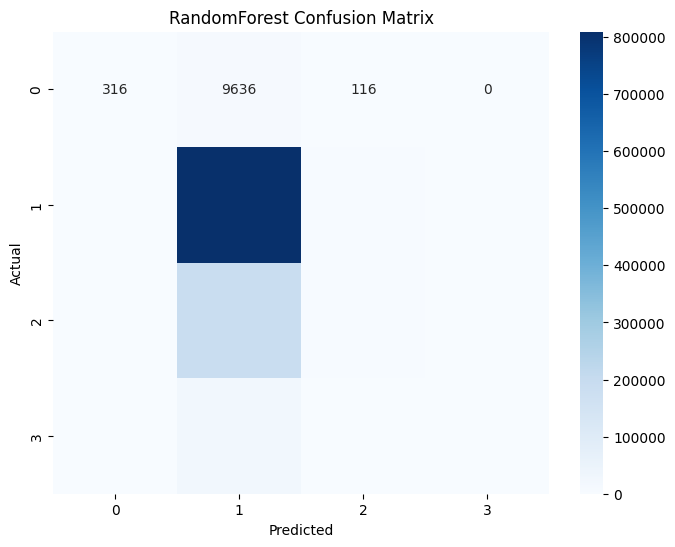

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone
import pandas as pd

def create_data_batches(X, y, batch_size):
    """Create batches of data"""
    for i in range(0, len(X), batch_size):
        yield X.iloc[i:i + batch_size], y[i:i + batch_size]

def batch_train_model(model, preprocessor, X, y, batch_size=1000):
    """Train a model using batch processing"""
    # Initialize the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clone(model))
    ])
    
    # Fit the preprocessor on the full dataset first to get all possible categories
    preprocessor.fit(X)
    
    # Train the model in batches
    for batch_num, (X_batch, y_batch) in enumerate(create_data_batches(X, y, batch_size)):
        print(f"Processing batch {batch_num + 1}...")
        
        # Transform the batch
        X_batch_transformed = preprocessor.transform(X_batch)
        
        # For the first batch, we need to call fit
        if batch_num == 0:
            pipeline.named_steps['classifier'].fit(X_batch_transformed, y_batch)
        else:
            # For LightGBM and other models that support partial_fit
            if hasattr(pipeline.named_steps['classifier'], 'partial_fit'):
                pipeline.named_steps['classifier'].partial_fit(X_batch_transformed, y_batch)
            else:
                # For models that don't support partial_fit, we'll need to accumulate data
                print("Warning: Model doesn't support partial_fit. Using full batch.")
                pipeline.named_steps['classifier'].fit(X_batch_transformed, y_batch)
    
    return pipeline

def batch_predict(pipeline, X, batch_size=1000):
    """Make predictions using batch processing"""
    all_predictions = []
    
    for i in range(0, len(X), batch_size):
        X_batch = X.iloc[i:i + batch_size]
        batch_predictions = pipeline.predict(X_batch)
        all_predictions.extend(batch_predictions)
    
    return np.array(all_predictions)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Adjust labels
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

# Define models
models = {
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        verbose=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Train and evaluate models
results = {}
BATCH_SIZE = 1000  # Adjust this based on your available memory

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model using batches
    pipeline = batch_train_model(model, preprocessor, X_train, y_train_adjusted, BATCH_SIZE)
    
    # Make predictions using batches
    y_pred = batch_predict(pipeline, X_val, BATCH_SIZE)
    
    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val_adjusted, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val_adjusted, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    results[name] = {
        'pipeline': pipeline,
        'val_score': np.mean(y_val_adjusted == y_pred)
    }